# Gosai et al. Human MPRA Dataset

## 1- Dataset preprocessing

In [ ]:
import wandb
import tempfile
import pandas as pd
wandb.login(host = "https://genentech.wandb.io" )
from grelu.resources import get_model_by_dataset, get_dataset_by_model

In [ ]:
# run = wandb.init(entity='zhao-yulai', project='human-mpra-gosai-2023', job_type='preprocessing', name='prep') # Initialize a W&B Run
# run.name

In [ ]:
# !wget https://www.biorxiv.org/content/biorxiv/early/2023/08/09/2023.08.08.552077/DC3/embed/media-3.zip?download=true
# !mv media-3.zip?download=true supp.zip
# !unzip -o supp.zip

In [ ]:
# df = pd.read_table('SupTable 2 - UKBB_GTEX_CODA_averaged_no_cutoffs.txt')

# df = df[((df.ctrl_mean_hepg2 >= 20) & (df.ctrl_mean_k562 >= 20)& (df.ctrl_mean_sknsh >= 20))]

# df['seq_len'] = df.nt_sequence.str.len()
# df = df[df.seq_len == 200].reset_index(drop=True)

# df = df[['chr', 'nt_sequence', 'HepG2_mean', 'K562_mean', 'SKNSH_mean']]
# df.columns = ['chrom', 'seq', 'hepg2', 'k562', 'sknsh']
# df['chrom'] = 'chr' + df.chrom.astype('str')

# df = df[~df.chrom.isin(['chrX', 'chrY'])] # blame David Garfield if this makes things worse

In [ ]:
# df.head()

### Save the dataset as a dataset artifact

In [ ]:
# artifact = wandb.Artifact('dataset', type='dataset')

# df.to_csv('dataset.csv.gz')
# artifact.add_file('dataset.csv.gz')
# run.log_artifact(artifact)

In [ ]:
# wandb.finish()

***

## 2- Model training

In [ ]:
import wandb
import torch
import grelu
import pandas as pd

# from grelu.resources import artifacts, get_model_by_dataset, get_dataset_by_model

wandb.login(host = "https://genentech.wandb.io" )

In [ ]:
import datetime
unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")

run_name = "Regression_EnformerPretrained_3tasks"
run_name += f"_{unique_id}"

run = wandb.init(entity ='zhao-yulai', project="RL-conditioning-DNA_oracles", name=run_name)

# run = wandb.init(entity='zhao-yulai', project='human-mpra-gosai-2023', job_type='training', name='train')
run.name

### Load the dataset

In [ ]:
# artifact = run.use_artifact('dataset:latest')
# artifact

In [ ]:
# dir = artifact.download()

In [13]:
df = pd.read_csv("artifacts/dataset:v2/dataset.csv.gz")
df.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


### Train/Val/Test split by chromosome

In [14]:
import grelu.data.preprocess

In [15]:
train_chroms = None
val_chroms   = ['chr7']
test_chroms  = ['chr13']

df_train, df_val, df_test = grelu.data.preprocess.split(
    df, 
    train_chroms=train_chroms,
    val_chroms=val_chroms,
    test_chroms=test_chroms,
)

df_train = df_train[['seq', 'hepg2', 'k562', 'sknsh']]
df_val = df_val[['seq', 'hepg2', 'k562', 'sknsh']]

Selecting training samples
Keeping 672966 intervals


Selecting validation samples
Keeping 42631 intervals


Selecting test samples
Keeping 19559 intervals
Final sizes: train: (672966, 6), val: (42631, 6), test: (19559, 6)


### Start the training!

In [16]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    'n_tasks': 3,
    'n_transformers': 3,
}

train_params = {
    'task':'regression',
    'loss': 'MSE',
    'lr':1e-4,
    'logger': 'wandb',
    'batch_size': 512,
    'num_workers': 4,
    'devices': [1],
    'save_dir': 'experiment',
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True,
}

In [17]:

import grelu.data.dataset

In [18]:
# Make labeled datasets
train_dataset = grelu.data.dataset.DFSeqDataset(df_train)
val_dataset   = grelu.data.dataset.DFSeqDataset(df_val)

# Build model
model =  grelu.lightning.LightningModel(model_params=model_params, train_params=train_params)

Sequences will be extracted from columns ['seq']
Sequences will be extracted from columns ['seq']


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [19]:
# Train model
trainer = model.train_on_dataset(train_dataset, val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████| 84/84 [00:10<00:00,  8.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             1.368315577507019
         val_mse             1.366013526916504
       val_pearson         -0.04956306144595146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 103 M  | train
1 | loss         | MSELoss                 | 0      | train
2 | activation   | Identity                | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
5 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
103 M     Trainable params
0         Non-trainable params
103 M     Total params
412.531   Total estimated model params size (MB)


/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 1315/1315 [03:01<00:00,  7.24it/s, v_num=b3vu, train_loss_step=0.149, train_loss_epoch=0.155]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1315/1315 [03:03<00:00,  7.16it/s, v_num=b3vu, train_loss_step=0.149, train_loss_epoch=0.155]


### Save the model

In [20]:
# artifact = wandb.Artifact('model', type='model')

# artifact.add_file(trainer.checkpoint_callback.best_model_path, 'model.ckpt')
# run.log_artifact(artifact)

In [21]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,▇█▇▆▅▅▅▄▂▄▄▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁
val_mse,█▁▁▁▁▁▁▁▁▁▁
val_pearson,▁██████████
epoch,9
train_loss_epoch,0.1553
train_loss_step,0.14923
trainer/global_step,13149


***

## 3- Test model

In [22]:
df_test = df_test[['seq', 'hepg2', 'k562', 'sknsh']]
test_dataset = grelu.data.dataset.DFSeqDataset(df_test)
model.test_on_dataset(test_dataset, devices=[1], num_workers=4)

Sequences will be extracted from columns ['seq']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 77/77 [00:02<00:00, 30.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30421045422554016
        test_mse            0.30447790026664734
      test_pearson          0.8458603620529175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
hepg2,0.260765,0.849171
k562,0.333811,0.843243
sknsh,0.318858,0.845167


### Correlation plots for each cell type

In [23]:
preds = model.predict_on_dataset(test_dataset, devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 77/77 [00:02<00:00, 35.03it/s]


In [24]:
from grelu.visualize import plot_pred_scatter

In [25]:
import numpy as np

### HepG2

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply


nan


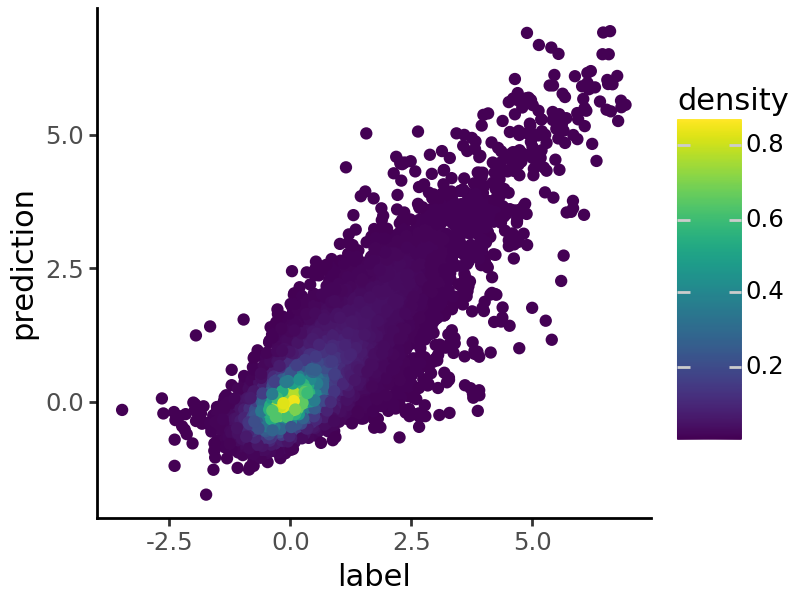

In [26]:
print(np.corrcoef(preds[:, 0], test_dataset.labels[:, 0])[0][1])
plot_pred_scatter(preds, test_dataset.labels, tasks=[0],  density = True) # hepg2

### K562

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply


nan


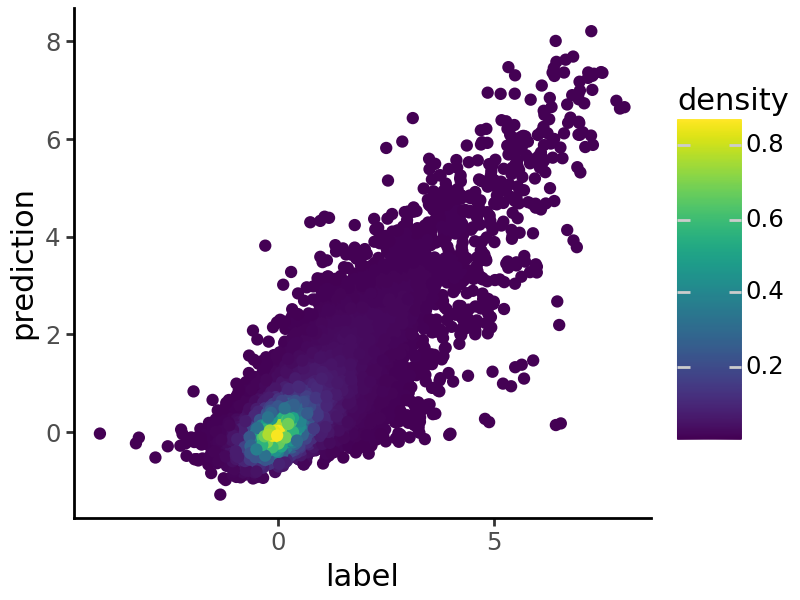

In [27]:
print(np.corrcoef(preds[:, 1], test_dataset.labels[:, 1])[0][1])
plot_pred_scatter(preds, test_dataset.labels, tasks=[1], density = True) # k562

### SKNSH

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply


nan


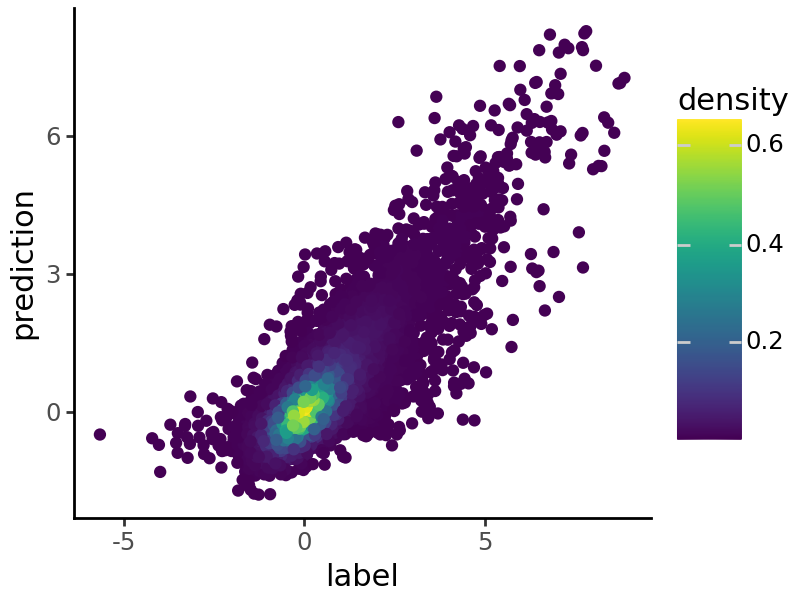

In [28]:
print(np.corrcoef(preds[:, 2], test_dataset.labels[:, 2])[0][1])
plot_pred_scatter(preds, test_dataset.labels, tasks=[2], density = True) # sknsh

## Query via gReLU Resources API

In [29]:
# get_model_by_dataset('dataset', 'human-mpra-gosai-2023')

In [30]:
# get_dataset_by_model('model', 'human-mpra-gosai-2023')

## Load model to test

In [31]:
# from grelu.resources import load_model

# model = load_model('human-mpra-gosai-2023', 'model')